Anomaly detection is a technique used in data science to identify unusual or abnormal patterns or observations within a dataset. It involves finding data points that deviate significantly from the expected behavior or the majority of the data. These anomalies can be indicative of errors, outliers, fraud, or unusual events in the data, and their detection is valuable in various domains, including cybersecurity, finance, manufacturing, and healthcare.  

---
  
  
Anomaly detection is useful in many ways. It helps in:

- Identifying errors: Anomalies can indicate data entry mistakes, sensor malfunctions, or measurement errors. By detecting these anomalies, data scientists can identify and correct errors, ensuring the reliability of the data.
- Fraud detection: Anomaly detection is extensively used in detecting fraudulent activities, such as credit card fraud, insurance fraud, or network intrusions. Unusual patterns in transactions or behaviors can be flagged as potential fraud, enabling timely intervention.
- System monitoring: Anomaly detection plays a crucial role in monitoring critical systems, such as manufacturing processes, network infrastructure, or healthcare systems. It helps in identifying deviations from normal operation, which can be early indicators of failures, security breaches, or equipment malfunctions.
- Quality control: Anomalies in manufacturing or production processes can signal product defects or equipment failures. By identifying these anomalies, companies can take corrective actions, improve product quality, and reduce waste.  

Anomaly detection is generally important because it provides insights into unusual occurrences that might go unnoticed through traditional analysis methods. By detecting anomalies, organizations can proactively address issues, mitigate risks, and make data-driven decisions, leading to improved operational efficiency, cost savings, and enhanced security.  

Let's explore anomaly detection in a simple example. Namely whether employees either get too much or too little salary.  
To that end, we first import the necessary modules and create some fake data.

In [9]:
# Imports
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from faker import Faker

In [10]:
# Employees
fake = Faker()
Faker.seed(42)
names = [fake.name() for x in range(100)]

# Salaries
np.random.seed(42)
salaries = [np.random.randint(1000, 2500) for x in range(100)]

# Create pandas DataFrame
salary_df = pd.DataFrame({"Person": names, "Salary (in USD)": salaries})

# Print a subsection of the DataFrame
print(salary_df.head())

            Person  Salary (in USD)
0     Allison Hill             2126
1      Noah Rhodes             2459
2  Angie Henderson             1860
3    Daniel Wagner             2294
4  Cristian Santos             2130


Now let's manually add some obvious outliers

In [11]:
salary_df.at[16, 'Salary (in USD)'] = 23
salary_df.at[65, 'Salary (in USD)'] = 17

# Verify, that the salaries were changed
print(salary_df.loc[16])
print(salary_df.loc[65])

Person             Holly Wood
Salary (in USD)            23
Name: 16, dtype: object
Person             Amber Kidd
Salary (in USD)            17
Name: 65, dtype: object


# Visualization to detect anomalies

Since these outliers are so obvious, we can easily visualize them using boxplots or even in histograms

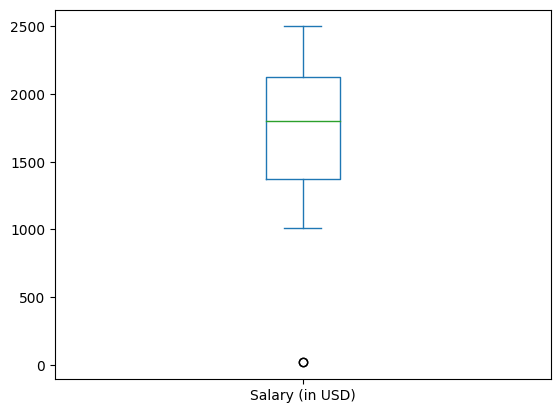

In [12]:
salary_df['Salary (in USD)'].plot(kind='box')
plt.show()

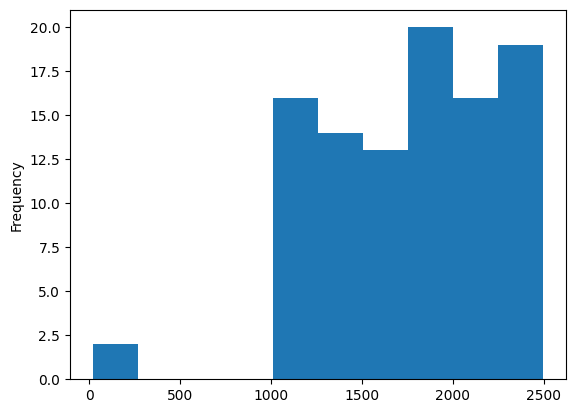

In [13]:
salary_df['Salary (in USD)'].plot(kind='hist')
plt.show()

This approach highlights clearly that one should always investigate the data thoroughly first. Always, investigate basic summary statistics, such as mean and median, for each of your features. Moreover, different visualizations can help to spot anomalies quite quickly as well.
However, often this is not enough to spot anomalies. For these cases, there is also additional approaches.

# Clustering

Clustering is one of these approaches. Clustering is closely related to anomaly detection and can thus be used to detect anomalies. Mathematically, similarity, a measurement for clustering, is measured by distance measurement functions such as Euclidean or Manhattan distance.
The K-Means clustering approach uses Euclidean distance internally so let's apply it to our fake data.

In [14]:
# We first need to reshape the salary data into an array of floats
salary_raw = salary_df['Salary (in USD)'].values
salary_raw = salary_raw.reshape(-1, 1).astype('float64')

In [15]:
# With kmeans we obtain the average Euclidean distance between the data points and the centroids generated by kmeans.
# Next, using the vq function, we can assign the actual clusters
centroids, avg_distance = scipy.cluster.vq.kmeans(salary_raw, 5)
groups, cdist = scipy.cluster.vq.vq(salary_raw, centroids)

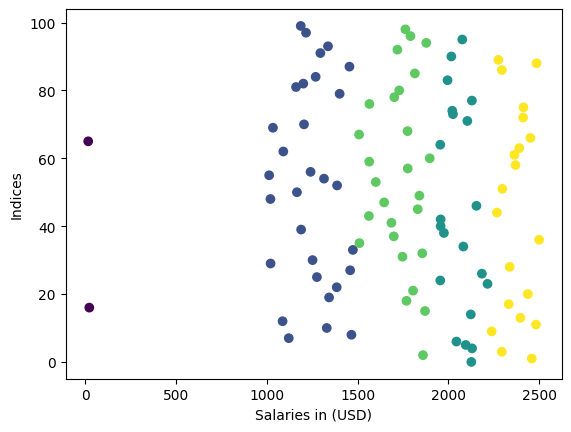

In [16]:
plt.scatter(salary_raw, np.arange(0,100), c=groups)
plt.xlabel('Salaries in (USD)')
plt.ylabel('Indices')
plt.show()

Although the choice of the number of clusters can be somewhat arbitrary, (KMeans) clustering can help to identify anomalies in your data.

## Anomaly detection using a classification approach

If we know beforehand what is and what is not an anomaly, we can also approach the detection of anomalies using classification methods.  
In order to do this for our example, we first need to transform the dataset into a labeled dataset. Let's assign `0`s to "normal" data points (salaries) and `1`s to "anomal" data points. We now have a *binary classification task*.

In [17]:
salary_df['class'] = 0
salary_df.at[16, 'class'] = 1
salary_df.at[65, 'class'] = 1
print(salary_df.loc[16])

Person             Holly Wood
Salary (in USD)            23
class                       1
Name: 16, dtype: object


We can now use *proximity-based anomaly detection* for finding anomalies.  
The basic idea is that the proximity of an anomal data point to its nearest neighboring data points largely deviates from the proximity of the data point to most of the other data points in the data set. We can use the non-parametric supervised learning method of *k-nearest neighbors algorithm*, or *k-NN*, to find class membership.

In [18]:
# Let's use sklearns knn classifier
from sklearn.neighbors import KNeighborsClassifier

X = salary_df["Salary (in USD)"].values.reshape(-1, 1)
y = salary_df["class"]

neigh = KNeighborsClassifier(n_neighbors=5, weights="distance")
neigh.fit(X, y)

KNeighborsClassifier(weights='distance')

In [19]:
# Let's return the predicted labels
print(neigh.predict(X))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


It is clear that our anomalies where capture by the KNN model. Now let's test the performance of our model by predicting whether the salary from a few new employees is an anomaly.

In [24]:
# This should definitely be an anomaly (an anomaly = 1)...
print(neigh.predict([[37]]))
# ...while this is more like a reasonable salary (no anomaly = 0)
print(neigh.predict([[1550]]))

[1]
[0]


Note though, that we will have trouble detecting anomalies of too high of a salary due to our training dataset as we didn't have a cluster at the highest end with a large enough distance to the second-highest cluster.

In [25]:
# This appears to be a clear anomaly on the higher end. Yet our model thinks this is fine!
print(neigh.predict([[10123550]]))

[0]


### Final thoughts
Although we seen multiple ways to approach anomaly detection in data, it is generally very *difficult to know what is considered normal or an anomaly*. This is where domain knowledge comes in. For our example, we only could give a clear definition because we have we knew what is a too low salary, since we defined the range at the beginning. Yet, it is easy to imagine scenarios, where even defining a range before is very difficult.  
Another challenge in these detection task is to *differentiate between an actual anomaly and noise* (particularly at the fringes of the range). Although noise is, from an operational point of view, all the same: it is information that cannot be captured (i.e. modelled) by the hypothesis. However, noise can come in two forms: _stochastic_ and _deterministic_ noise. Stochastic noise describes random fluctuations or measurement errors in the data which are not modelled, while deterministic noise occurs when the phenomenon is more complex than can be captured by a simplified hypothesis. Note that it might be tempting to increase model complexity to eliminate the impact of deterministic noise. However, this will always come at the cost of generalizability as adding complexity will limit the model to extrapolate the pattern to other data.  
In any event, _both_ types of noise lead to overfitting in your model and thus to poorer performance. Specifically, when the amount of deterministic noise tends to be very high, it often reduces the boundary between the normal and abnormal data points. Sometimes, it so happens that an anomaly is considered as a noisy data point and vice versa. This can, in turn, change the whole course of the anomaly detection process. We can understand noise as the cause of the disease that becomes overfitting in your models. The cure is regularization (i.e., punishing complex models) and validation (i.e., a reality check for your models predictions) but it is unlikely that you can ever prevent the cause altogether.